# Dataset

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import numpy as np

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [28]:
# Load the IMDB dataset
max_features = 5000  # Number of words to consider as features
max_len = 500  # Cut texts after this number of words (among top max_features most common words)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [29]:
# Pad sequences to ensure uniform length
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [30]:
# Create DataLoader
batch_size = 64

train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# RNN

In [31]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Model hyperparameters
vocab_size = max_features
embedding_dim = 128
hidden_dim = 128
output_dim = 1
num_layers = 3  # Number of RNN layers

# Initialize the model, criterion and optimizer
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

In [32]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.6561
Epoch [2/5], Loss: 0.5698
Epoch [3/5], Loss: 0.5963
Epoch [4/5], Loss: 0.5429
Epoch [5/5], Loss: 0.4840


In [33]:
# Evaluate the model
rnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = rnn_model(inputs)
        predicted = (outputs.squeeze() >= 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7510


# LSTM

In [34]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Model hyperparameters
vocab_size = max_features
embedding_dim = 128
hidden_dim = 128
output_dim = 1
num_layers = 3  # Number of LSTM layers

# Initialize the model, criterion and optimizer
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [35]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.5672
Epoch [2/5], Loss: 0.4956
Epoch [3/5], Loss: 0.4427
Epoch [4/5], Loss: 0.2926
Epoch [5/5], Loss: 0.2354


In [36]:
# Evaluate the model
lstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = lstm_model(inputs)
        predicted = (outputs.squeeze() >= 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8670


# GRU

In [37]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x = x[:, -1, :]  # Take the output of the last time step
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Model hyperparameters
vocab_size = max_features
embedding_dim = 128
hidden_dim = 128
output_dim = 1
num_layers = 3  # Number of GRU layers

# Initialize the model, criterion and optimizer
gru_model = GRUModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

In [38]:
# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    gru_model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.5621
Epoch [2/5], Loss: 0.3173
Epoch [3/5], Loss: 0.2216
Epoch [4/5], Loss: 0.1709
Epoch [5/5], Loss: 0.1188


In [39]:
# Evaluate the model
gru_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = gru_model(inputs)
        predicted = (outputs.squeeze() >= 0.5).float()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8770


In [40]:
!pip install torchviz

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [48]:
from torchviz import make_dot

# Example input
example_input = torch.randint(0, vocab_size, (1, max_len)).to(device)

# Get model output
rnn_o = rnn_model(example_input)
lstm_o = lstm_model(example_input)
gru_o = gru_model(example_input)

# Create visualization
rnn_viz = make_dot(rnn_o, params=dict(rnn_model.named_parameters()))
lstm_viz = make_dot(lstm_o, params=dict(lstm_model.named_parameters()))
gru_viz = make_dot(gru_o, params=dict(gru_model.named_parameters()))

# Save to file
rnn_viz.render('visualization/rnn_model', format='png')
lstm_viz.render('visualization/lstm_model', format='png')
gru_viz.render('visualization/gru_model', format='png')

'visualization/gru_model.png'

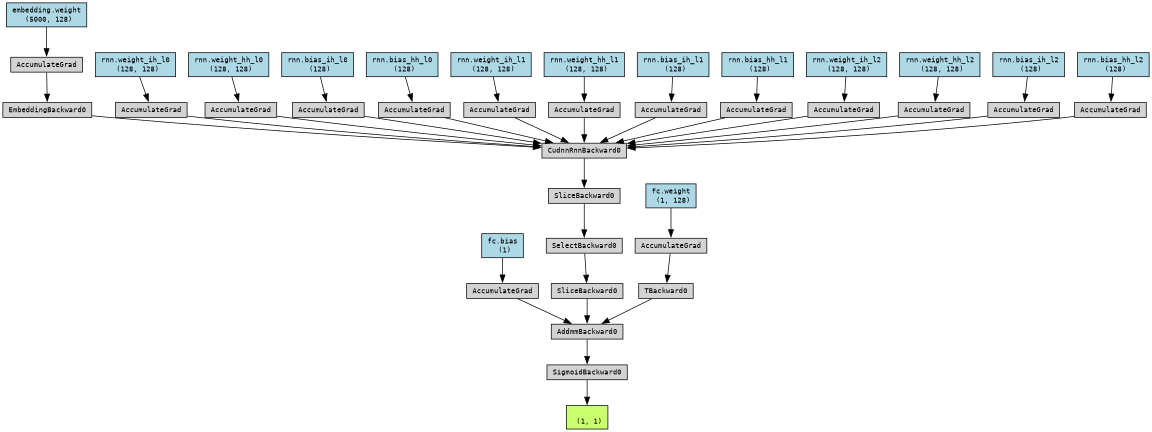

In [49]:
from IPython.display import Image

# Specify the path to your saved visualization file
rnn_image = 'visualization/rnn_model.png'
lstm_image = 'visualization/lstm_model.png'
gru_image = 'visualization/gru_model.png'

# Display the image
Image(filename=rnn_image)

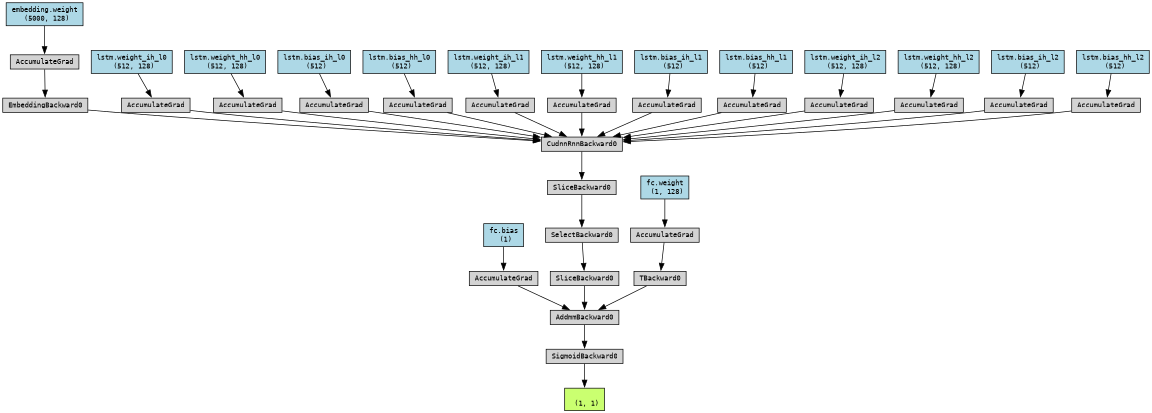

In [50]:
Image(filename=lstm_image)

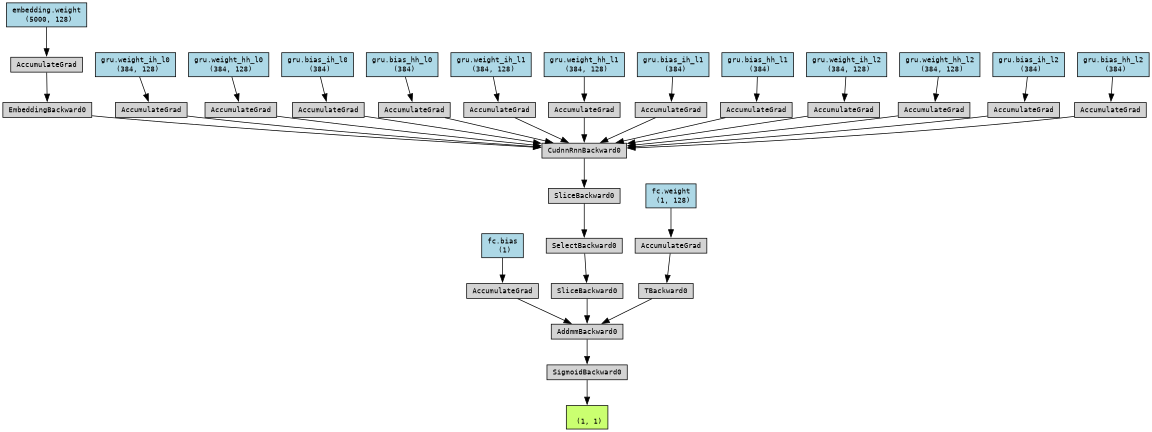

In [51]:
Image(filename=gru_image)